# Reducing ill conditioned Markov Chains with Graph Transformation (GT)

This cell loads our `PyGT` package, `tqdm` for progress bars, and defines some helper functions

In [125]:
!pip install PyGT tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
import os.path as Path
from PyGT.io import load_ktn
from PyGT.GT import blockGT
from PyGT.mfpt import full_MFPT_matrix
from PyGT.stats import compute_passage_stats as fpt

from scipy.sparse import diags,eye,issparse
from tqdm.notebook import tqdm

def ev(Q):
    nu = spla.eigvals(Q)
    return np.sort(-nu.real)

def select_states_to_remove(B_matrix,participation):
    N_states = B_matrix.shape[0]
    denseB = np.zeros(B.shape)
    B.todense(out=denseB)

    connections = denseB>0

    rm_vec = np.ones(N_states,bool)

    for i in range(N):
        # boundary nodes
        if not (participation[connections[i]]==participation[i]).min():
            rm_vec[i] = False

        # local minima
        if (u)[participation == participation[i]].min()==(u)[i]:
            rm_vec[i] = False
    print(f"""
        Retained Nodes: {N_states-rm_vec.sum()}
    """)
    return rm_vec

def condition_number_estimation(Q):
    if issparse(Q):
        MQ = Q.todense().copy()
    else:
        MQ = Q.copy()
    MQ -= np.diag(np.diag(MQ))
    return np.linalg.cond(MQ)




## Load 9-macrostate model and BACE-defined community participation

In [126]:
data_path = 'example-data-9-communities/'

T = 1e0

B, K, tau, N, u, s, Emin, retained = \
  load_ktn(path=data_path,beta=1.0/T,screen=True)

Q = K-diags(1.0/tau)

full_cond = condition_number_estimation(B)
print(f"""
    Estimated condition number of B: {full_cond}
    """)

pi = np.exp(-u/T+s)
pi /= pi.sum()



communities = \
  np.loadtxt(Path.join(data_path,'communities_bace9.dat')).astype(int)


for ic in zip(*np.unique(communities,return_counts=True)):
    print("\tCommunity",ic[0]+1,":",ic[1],"states")



	Connected Clusters: 1, of which 95% have <= 994 states
	Retaining largest cluster with 994 nodes


    Estimated condition number of B: 42482577299.51341
    
	Community 1 : 112 states
	Community 2 : 130 states
	Community 3 : 89 states
	Community 4 : 147 states
	Community 5 : 110 states
	Community 6 : 85 states
	Community 7 : 186 states
	Community 8 : 98 states
	Community 9 : 37 states


## Find boundary nodes and community minima, then perform GT reduction

(2, 215)

In [127]:
# boolean vector of states to remove
rm_vec = select_states_to_remove(B,communities)

retained_states = ~rm_vec.copy()
#print(retained_states)

# block GT reduction
r_B, r_tau, r_Q = blockGT(rm_vec,B,tau,block=50,rates=True,screen=True)

r_Q_d = r_Q.toarray()
print("r_Q_d " + str(r_Q_d))
print("shape " + str(r_Q_d.shape))
#if issparse(r_Q):
    #r_Q_d = r_Q.todense().copy()

    
#print(r_Q_d.shape)
#print("r_Q_d " + str(r_Q_d))
#print("r_Q_d[0][0] " +  str(r_Q_d[0]))
#print(r_Q_d[0].shape)
#print("rQ_d " + str(r_Q_d))
#print("################################")

#r_tau: array of renormalised waiting times
#tau: array of full network waiting times
r_pi = pi[retained_states] * r_tau / tau[retained_states]
#Saving the stationary distribution for reduced network to file
np.savetxt(Path.join(data_path, 'esmae_reduced_stat_prob.dat'), np.log(r_pi),fmt="%.16f")


r_ids = np.arange(communities.size)[retained_states] 
r_communities = communities[retained_states]

#Producing community files for reduced network
#Open all comms files
COMM_PATTERN = data_path + "esmae_reduced_comms"
all_comms = np.arange(9)
cfiles = []
for ci in range(len(all_comms)):
        cfilename=COMM_PATTERN+str(all_comms[ci])+".dat"
        print(cfilename)
        cfile = open(cfilename,"w")
        cfiles.append(cfile)
        
        
for i in range(len(r_communities)):
    c = r_communities[i]
    node = i+1
    cfiles[c-1].writelines(str(node) + '\n')
    
for file in cfiles:
    file.close()
    
#np.savetxt(Path.join,'esmae_reduced_comms' + str(i) + '.dat'), np.stack(

# save files
np.savetxt(Path.join(data_path,'esmae_reduced_communities_bace9.dat'),
           np.stack((r_ids + 1,r_communities)).T,fmt="%d %d",header="NB: nodes are indexed from one, communities are 0-indexed !")

#save edge_conns.dat and edge_weights.dat files for discotress

connA = []
connB = []
r1 = []
r2 = []

        
for i in range(retained_states.sum()):
    for j in range(retained_states.sum()):
        if r_Q_d[i][j]:
            if i<j: 
                connA.append(i+1)
                connB.append(j+1)
                r1.append(np.log(r_Q_d[i][j]))
                r2.append(np.log(r_Q_d[j][i]))
                
                #print("i:" + str(i) + " j:" + str(j) + " " + str(r_Q_d[i][j]))
                
np.savetxt(Path.join(data_path, 'esmae_reduced_edge_conns.dat'), np.stack((connA, connB)).T,fmt="%d %d")
#print('{:<10s}{:>4s}{:>12s}{:>12s}'.format(data[i][0],data[i][1],data[i][2],data[i][3]))
np.savetxt(Path.join(data_path, 'esmae_reduced_edge_weights.dat'), np.stack((r2, r1)).T, fmt="%.16f %.16f", delimiter=' ')

r_full_cond = condition_number_estimation(r_B)
print(f"""
    Estimated condition number of    B: {full_cond:.2f}
    Estimated condition number of GT_B: {r_full_cond:.2f} 
""")


        Retained Nodes: 215
    


GT:   0%|          | 0/779 [00:00<?, ?it/s]

GT removed 779 nodes in 0.072 seconds with 0 floating point corrections
r_Q_d [[-7.76081121e-04  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.51023667e-02  0.00000000e+00 ...  0.00000000e+00  1.41344569e-19  4.68473675e-18]
 [ 0.00000000e+00  0.00000000e+00 -2.63974767e-05 ...  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.26743430e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.03192201e-19  0.00000000e+00 ...  0.00000000e+00 -1.48846673e-02  2.43536411e-03]
 [ 0.00000000e+00  1.36955371e-18  0.00000000e+00 ...  0.00000000e+00  4.95256142e-04 -2.33995334e-02]]
shape (215, 215)
example-data-9-communities/esmae_reduced_comms0.dat
example-data-9-communities/esmae_reduced_comms1.dat
example-data-9-communities/esmae_reduced_comms2.dat
example-data-9-communities/esmae_reduced_comms3.dat
example-data-9-communities/esmae_reduced_comms4.dat
example-data-9-commun

## First passage time distributions


  0%|          | 0/6 [00:00<?, ?it/s]

sum should be 2 2.0
sum should be 2 2.0
sum should be 2 2.0
CA 3
CB 2
r_mfpt [2.42187280e+12 1.35639454e+25 7.10768177e+11 1.03341718e+24]
sum should be 2 2.0
sum should be 2 2.0
sum should be 2 2.0
CA 4
CB 2
r_mfpt [1.81101282e+12 9.81763051e+24 1.23998205e+12 3.91350073e+24]
sum should be 2 2.0
sum should be 2 1.9999999999999998
sum should be 2 1.9999999999999998
CA 4
CB 3
r_mfpt [3.96214697e+11 3.92627814e+23 9.74085494e+11 2.53774764e+24]
sum should be 2 2.0
sum should be 2 2.0
sum should be 2 2.0
CA 5
CB 2
r_mfpt [3.02466124e+12 1.70582093e+25 2.10927522e+12 7.53669132e+24]
sum should be 2 2.0
sum should be 2 2.0
sum should be 2 2.0
CA 5
CB 3
r_mfpt [4.86786034e+11 5.61190734e+23 1.53340110e+12 5.04688610e+24]
sum should be 2 1.9999999999999998
sum should be 2 2.0
sum should be 2 2.0
CA 5
CB 4
r_mfpt [1.11486123e+12 2.75325728e+24 1.81383025e+12 6.03199081e+24]


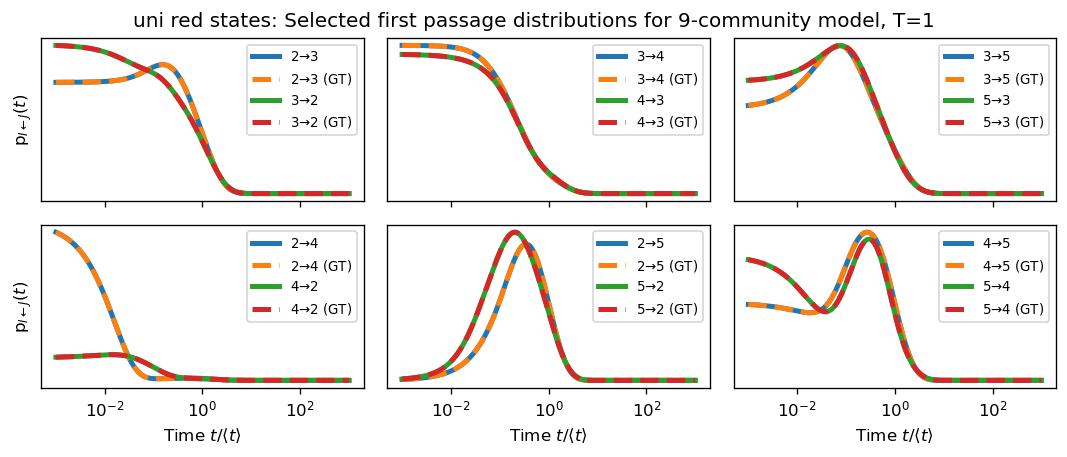

In [142]:
fig,axs = plt.subplots(2,3,figsize=(9,4),dpi=120,sharex='col')
fig.patch.set_facecolor('white')
cc = 0
pbar = tqdm(total=6)
for cA in range(2,6):
    for cB in range(2,6):
        if cA>cB:
            #Communities are labelled 0...8
            A_sel = communities==cA-1 #Numpy array of True and Falses for each node, True if in community cA
            B_sel = communities==cB-1
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]
            fr_A_sel = A_sel
            for i in range(0,len(fr_A_sel)):
                if not retained_states[i]:
                    fr_A_sel=False
                    
            #print("retained states " + str(retained_states))

            #Uniform distribution
            #Full network
            p_0_uni = np.zeros(pi.shape)
            p_0_uni[A_sel] = 1/A_sel.sum()
            p_0_uni[B_sel] = 1/B_sel.sum()
            print("sum should be 2 " + str(p_0_uni.sum()))
            #reduced network
            r_p_0_uni = np.zeros(retained_states.sum())
            r_p_0_uni[r_A_sel] = 1/r_A_sel.sum()
            r_p_0_uni[r_B_sel] = 1/r_B_sel.sum()
            print("sum should be 2 " + str(r_p_0_uni.sum()))
            #Full network uniform but only for reduced nodes
            p_0_uni2 = np.zeros(pi.shape)
            p_0_uni2[retained_states] = r_p_0_uni
            #p_0_uni2[A_sel] *= 1/r_A_sel.sum()
            #p_0_uni2[B_sel] *= 1/r_B_sel.sum()
            #p_0_uni2[!retained_states] = 0.0
            #print("p_0_uni2 " + str(p_0_uni2))
            print("sum should be 2 " + str(p_0_uni2.sum()))
            
        
        
            # define initial distribution as in paper
            p_0 = np.zeros(pi.shape)
            p_0[A_sel] = np.arange(A_sel.sum()) == pi[A_sel].argmax() #RHS: Index of minimum of A_sel community
            p_0[B_sel] = np.arange(B_sel.sum()) == pi[B_sel].argmax()

            # define same quantities for GT reduced system
            r_p_0 = p_0[retained_states]
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]

            # mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            #print("p_0 " + str(p_0))
            mfpt,fptd = fpt(A_sel=A_sel,B_sel=B_sel,pi=p_0_uni2,K=Q,dopdf=True)


            # r_mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            #print("r_p_0 " + str(r_p_0))
            r_mfpt,r_fptd = \
                fpt(A_sel=r_A_sel,B_sel=r_B_sel,pi=r_p_0_uni,K=r_Q,dopdf=True)
            print("CA " + str(cA))
            print("CB " + str(cB))
            print("r_mfpt " + str(r_mfpt))
            #Saving reduced data to file
            np.savetxt("data/fpt_py_" + str(cA) + str(cB) + "uni.dat",np.stack((r_fptd[:,3],r_fptd[:,2])).T)
            i,j = cc%2,cc//2
            #print(i)
            #print(j)
            axs[i,j].semilogx(fptd[:,2]/mfpt[2],fptd[:,3],lw=3,
                            label=fr"{cB}$\to${cA}")
            axs[i,j].semilogx(r_fptd[:,2]/mfpt[2],r_fptd[:,3],'--',lw=3,
                            label=fr"{cB}$\to${cA} (GT)")

            axs[i,j].semilogx(fptd[:,0]/mfpt[0],fptd[:,1],lw=3,
                            label=fr"{cA}$\to${cB}")
            axs[i,j].semilogx(r_fptd[:,0]/mfpt[0],r_fptd[:,1],'--',lw=3,
                            label=fr"{cA}$\to${cB} (GT)")

            axs[i,j].set_yticks([])
            if i==0:
                axs[i,j].set_xticks([])
            else:
                axs[i,j].set_xlabel(r"Time $t/\langle{t}\rangle$")

            if j==0:
                axs[i,j].set_ylabel(r"${\rm p}_{I\leftarrow J}(t)$")

            axs[i,j].legend(fontsize=8)
            cc+=1
            pbar.update(1)
plt.suptitle("uni red states: Selected first passage distributions for 9-community model,"
  f" T={int(T)}",y=0.94)
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig(f"pdf_comp_T{int(T)}.pdf")
plt.show()